In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from google.colab import files
myfile = files.upload()

Saving onlinedeliverydata.csv to onlinedeliverydata.csv


In [ ]:
# 원본자료확인
df = pd.read_csv(io.BytesIO(myfile['onlinedeliverydata.csv']))
df

In [86]:
# 주문방법 중 배달앱 사용자만 선택, 총 55개 변수 중 주제와 관련있을 변수들을 선정 
df_d1 = df.loc[df['Medium (P1)']=='Food delivery apps',['Age', 'Gender', 'Marital Status', 'Occupation', 'Monthly Income',
        'Family size', 'Time saving', 'Late Delivery',
        'Long delivery time', 'Delay of delivery person getting assigned',
        'Influence of time', 'Order Time', 'Maximum wait time', 'Less Delivery time',
        'Output']]

In [ ]:
# 데이터 확인
df_d1

In [ ]:
# 결측값 존재 여부 확인 -> 없음
df_d1.info()

In [ ]:
# 기술통계 확인. 평균나이 24.6세, 평균가족구성원 3.2명
df_d1.describe()

,Age,Family size
count,358.000000,358.000000
mean,24.656425,3.262570
std,2.945224,1.361041
min,18.000000,1.000000
25%,23.000000,2.000000
50%,24.000000,3.000000
75%,26.000000,4.000000
max,33.000000,6.000000


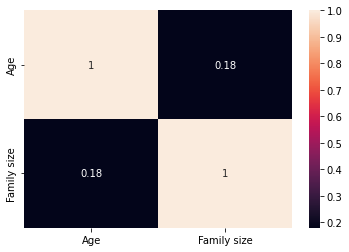

In [ ]:
# 변수 간의 상관관계 확인
corr = df_d1.corr()
sns.heatmap(corr, annot=True)

#상관관계 분석할 number값 변수들 부족 -> 서열척도, 비율척도 문항 number로 변환하고 다시 분석

In [79]:
# 변수들의 상세사항과 척도를 보기 쉽게 확인하기 위해 데이터프레임 생성. 
# [열2] 상세사항을 알기 위해 kaggles 해당 출처에서의 추가 설명을 삽입
# [열3] A/B마케팅이나 군집마케팅 어디에 적합할지 보기 위한 척도 구분 작업
# 서열척도, 비율척도도 number로 변환하여 상관관계와 검정값을 구하고자 한다. 
# 비율(수) = 이미 number로 되어있는 값들
# 비율척도는 모두 number로 변환할 예정 
# 서열척도는 항목의 성격을 고려하여 1~5의 number로 변환할 예정
df_d1_scale = pd.DataFrame({'변수':['Age', 'Gender', 'Marital Status', 'Occupation', 'Monthly Income',
        'Family size', 'Time saving', 'Late Delivery',
        'Long delivery time', 'Delay of delivery person getting assigned',
        'Influence of time', 'Order Time', 'Maximum wait time', 'Less Delivery time',
        'Output'], 
        '상세' :['Age of Consumer', 'Gender of Consumer', 'Marital Status of Consumer', 'Job or Occupation status of Consumer',
               'Income bracket of consumer', 'Number of family members/ friends living with', 'Does it save time ?',
               'Later Delivery causes not purchasing', 'Long delivery causes cancellation', 
               'Delay of delivery person assigned causes cancel', 'Is there any influence in time ?', 
               'When do you order?', 'How long can you wait ?', 'Importance of Less delivery time','Will I purchase again ?']
        ,'척도':['비율(수)', '명목', '명목', '명목', '비율', '비율(수)', '서열',
                          '서열', '서열', '서열', '명목', '명목', '비율', '서열', '명목']})

df_d1_scale

,변수,상세,척도
0,Age,Age of Consumer,비율(수)
1,Gender,Gender of Consumer,명목
2,Marital Status,Marital Status of Consumer,명목
3,Occupation,Job or Occupation status of Consumer,명목
4,Monthly Income,Income bracket of consumer,비율
5,Family size,Number of family members/ friends living with,비율(수)
6,Time saving,Does it save time ?,서열
7,Late Delivery,Later Delivery causes not purchasing,서열
8,Long delivery time,Long delivery causes cancellation,서열
9,Delay of delivery person getting assigned,Delay of delivery person assigned causes cancel,서열


In [55]:
# 변수의 선택지 내용 확인
# 서열, 비율 척도에서 숫자로 바꿀 변수들만 확인(선택지5개인것들)
for a in df_d1.columns:
     if len(df_d1[a].value_counts())==5:
         print("*****************")
         print('변수명 : '+a)
         print(df_d1[a].value_counts())
         

*****************
변수명 : Monthly Income
No Income          172
25001 to 50000      67
More than 50000     59
10001 to 25000      42
Below Rs.10000      18
Name: Monthly Income, dtype: int64
*****************
변수명 : Time saving
Agree                130
Strongly agree       106
Disagree              64
Neutral               51
Strongly disagree      7
Name: Time saving, dtype: int64
*****************
변수명 : Late Delivery
Agree                153
Neutral               75
Disagree              71
Strongly disagree     32
Strongly agree        27
Name: Late Delivery, dtype: int64
*****************
변수명 : Long delivery time
Agree                169
Disagree             102
Neutral               45
Strongly agree        35
Strongly disagree      7
Name: Long delivery time, dtype: int64
*****************
변수명 : Delay of delivery person getting assigned
Agree                126
Neutral              100
Disagree              63
Strongly agree        51
Strongly disagree     18
Name: Delay of delivery

In [100]:
df_d2 = df_d1 #데이터프레임 복사
for a in df_d1.columns:
      if len(df_d2[a].value_counts())==5: 
          #모든 서열척도->숫자로 변환
          df_d2.loc[df_d2[a]=='Strongly agree',a] = 5
          df_d2.loc[df_d2[a]=='Agree',a] = 4
          df_d2.loc[df_d2[a]=='Neutral',a] = 3
          df_d2.loc[df_d2[a]=='Disagree',a] = 2
          df_d2.loc[df_d2[a]=='Strongly disagree',a] = 1

          df_d2.loc[df_d2[a]=='Very Important',a] = 5
          df_d2.loc[df_d2[a]=='Important',a] = 4
          df_d2.loc[df_d2[a]=='Moderately Important',a] = 3
          df_d2.loc[df_d2[a]=='Slightly Important',a] = 2
          df_d2.loc[df_d2[a]=='Unimportant',a] = 1

          #Montly Income값 변환
          df_d2.loc[df_d2[a]=='No Income',a] = 0
          df_d2.loc[df_d2[a]=='Below Rs.10000',a] = 5000
          df_d2.loc[df_d2[a]=='10001 to 25000',a] = 17500
          df_d2.loc[df_d2[a]=='25001 to 50000',a] = 37500
          df_d2.loc[df_d2[a]=='More than 50000',a] = 50000

          #Maximum wait time값 변환
          df_d2.loc[df_d2[a]=='More than 60 minutes',a] = 100
          df_d2.loc[df_d2[a]=='60 minutes',a] = 60
          df_d2.loc[df_d2[a]=='45 minutes',a] = 45
          df_d2.loc[df_d2[a]=='30 minutes',a] = 30
          df_d2.loc[df_d2[a]=='15 minutes',a] = 15

# 값이 바뀌었는지 확인
for a in df_d2.columns:
     if len(df_d2[a].value_counts())==5:
         df_d2 = df_d2.astype({a:'int'}) #문자타입을 숫자타입으로 변환
         print("*****************")
         print('변수명 : '+a)
         print(df_d2[a].value_counts())

*****************
변수명 : Monthly Income
1        172
37500     67
50000     59
17500     42
5000      18
Name: Monthly Income, dtype: int64
*****************
변수명 : Time saving
4    130
5    106
2     64
3     51
1      7
Name: Time saving, dtype: int64
*****************
변수명 : Late Delivery
4    153
3     75
2     71
1     32
5     27
Name: Late Delivery, dtype: int64
*****************
변수명 : Long delivery time
4    169
2    102
3     45
5     35
1      7
Name: Long delivery time, dtype: int64
*****************
변수명 : Delay of delivery person getting assigned
4    126
3    100
2     63
5     51
1     18
Name: Delay of delivery person getting assigned, dtype: int64
*****************
변수명 : Maximum wait time
45     147
30     121
15      37
60      32
100     21
Name: Maximum wait time, dtype: int64
*****************
변수명 : Less Delivery time
4    226
5     56
3     41
2     31
1      4
Name: Less Delivery time, dtype: int64


In [101]:
#형변환 확인
df_d2.dtypes

Age                                           int64
Gender                                       object
Marital Status                               object
Occupation                                   object
Monthly Income                                int64
Family size                                   int64
Time saving                                   int64
Late Delivery                                 int64
Long delivery time                            int64
Delay of delivery person getting assigned     int64
Influence of time                            object
Order Time                                   object
Maximum wait time                             int64
Less Delivery time                            int64
Output                                       object
dtype: object

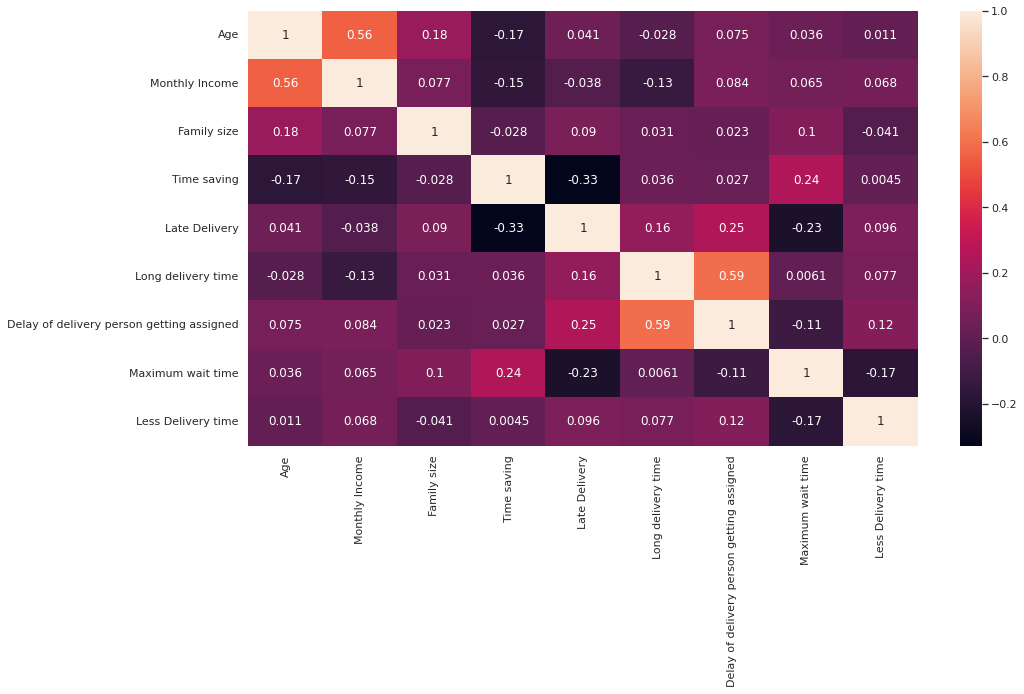

In [104]:
#상관관계 확인
corr = df_d2.corr()
sns.set(rc = {'figure.figsize':(15,8)}) #사이즈 확대
sns.heatmap(corr, annot=True)

In [113]:
# # 변수 간의 관계를 시각화 ->의미없음
# sns.pairplot(df_d2)
